# Importing libraries and functions

In [1]:
# Data Handling
import pandas as pd
import numpy as np
pd.set_option("display.max_column", None)
pd.set_option('display.max_rows', None)

# Visualisations:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Encoders:
from sklearn.preprocessing import LabelEncoder

# Modelling and forecasting
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.forecasting.arima import AutoARIMA

# Importing modules
import sys
sys.path.append('../src/modules')
from Modules import NaNs_calculator, bar_plot, plot_trend, sktime_forecast

import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data pre-processing

In [2]:
# Imporing data:
df = pd.read_csv(r'../data/global-data-on-sustainable-energy.csv')
df.iloc[:5,:]

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,65.957440,302.59482,1.64,760.000000,NaN,NaN,NaN,60,"6,52,230",33.93911,67.709953
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,84.745766,236.89185,1.74,730.000000,NaN,NaN,NaN,60,"6,52,230",33.93911,67.709953
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,81.159424,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,"6,52,230",33.93911,67.709953
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,67.021280,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,"6,52,230",33.93911,67.709953
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,62.921350,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,"6,52,230",33.93911,67.709953


Since the analysis focuses on CO₂ and energy consumption, we can exclude the other variables that do not contribute significantly to this objective. The columns to retain are:

- Year
- Entity
- The two target variables (as previously mentioned)

In a future version I am developing, I plan to adopt a more robust framework to support multivariate analysis and visualisation with Streamlit library.

In [3]:
# Define a list of the three countries
columns_df = ['Colombia', 'United Kingdom', 'Thailand'] # final data set

# Applying boolean mask to select only the rows where the country is located
mask = df['Entity'].isin(columns_df)
filtered_df = df[mask].reset_index(drop = True)

# Getting the targets
final_df = filtered_df.iloc[:,[0,
                       1,
                       filtered_df.columns.get_loc('Primary energy consumption per capita (kWh/person)'),
                       filtered_df.columns.get_loc('Value_co2_emissions_kt_by_country')]]

# Replacing space by '_' (for convenience)
final_df = final_df.rename(columns={
    'Value_co2_emissions_kt_by_country': 'Co2 Emissions per country',
    'Primary energy consumption per capita (kWh/person)': 'Energy consumption per capita (kwh/person)'
})

final_df.iloc[:5, :]

,Entity,Year,Energy consumption per capita (kwh/person),Co2 Emissions per country
0,Colombia,2000,8011.8125,58340.00000
1,Colombia,2001,7953.8550,58940.00000
2,Colombia,2002,7834.4710,56770.00046
3,Colombia,2003,7863.6520,56110.00061
4,Colombia,2004,8152.3345,56110.00061


## Verifying duplicates

In [4]:
print('FILTERED DATA:')
pd.Series({'No. duplicated rows:': final_df.duplicated().sum()})

FILTERED DATA:


No. duplicated rows:    0
dtype: int64

## Verifying missing data

In [5]:
NaNs_calculator(final_df)

,NAMES,VALUE COUNT,PERCENTAGE (%),DATA TYPE
0,Co2 Emissions per country,3,4.762,float64
1,Entity,0,0.000,object
2,Year,0,0.000,int64
3,Energy consumption per capita (kwh/person),0,0.000,float64


## Removing

In [6]:
# IMPUTING VALUES:
final_df = final_df.dropna()
NaNs_calculator(final_df)

,NAMES,VALUE COUNT,PERCENTAGE (%),DATA TYPE
0,Entity,0,0.0,object
1,Year,0,0.0,int64
2,Energy consumption per capita (kwh/person),0,0.0,float64
3,Co2 Emissions per country,0,0.0,float64


# Stats per country
## Colombia

In [7]:
final_df[final_df['Entity'] == 'Colombia'].describe().T

,count,mean,std,min,25%,50%,75%,max
Year,20.0,2009.500000,5.916080,2000.00000,2004.750000,2009.500000,2014.250000,2019.00000
Energy consumption per capita (kwh/person),20.0,9543.695350,1315.251800,7834.47100,8117.204000,9398.531500,10602.181000,11435.30300
Co2 Emissions per country,20.0,66925.999512,9947.048279,56110.00061,58177.499657,62784.999845,77292.499543,82680.00031


## United Kingdom

In [8]:
final_df[final_df['Entity'] == 'United Kingdom'].describe().T

,count,mean,std,min,25%,50%,75%,max
Year,20.0,2009.500000,5.916080,2000.0000,2004.750000,2009.5000,2014.250000,2019.000
Energy consumption per capita (kwh/person),20.0,39601.819950,4639.703248,32893.7600,34813.682500,39290.2840,44437.350750,45559.023
Co2 Emissions per country,20.0,470603.999635,70179.706516,348920.0134,411970.001225,475110.0006,533397.495725,545260.000


## Thailand

In [9]:
final_df[final_df['Entity'] == 'Thailand'].describe().T

,count,mean,std,min,25%,50%,75%,max
Year,20.0,2009.50000,5.916080,2000.000,2004.750000,2009.50000,2014.250000,2019.0000
Energy consumption per capita (kwh/person),20.0,16985.01665,2808.454141,11764.549,15431.365250,16821.80400,19398.378500,20834.0880
Co2 Emissions per country,20.0,228940.50018,31648.291170,164490.000,215875.003825,230590.00395,257492.492675,267089.9963


# Carbon emission and energy consumtion per country

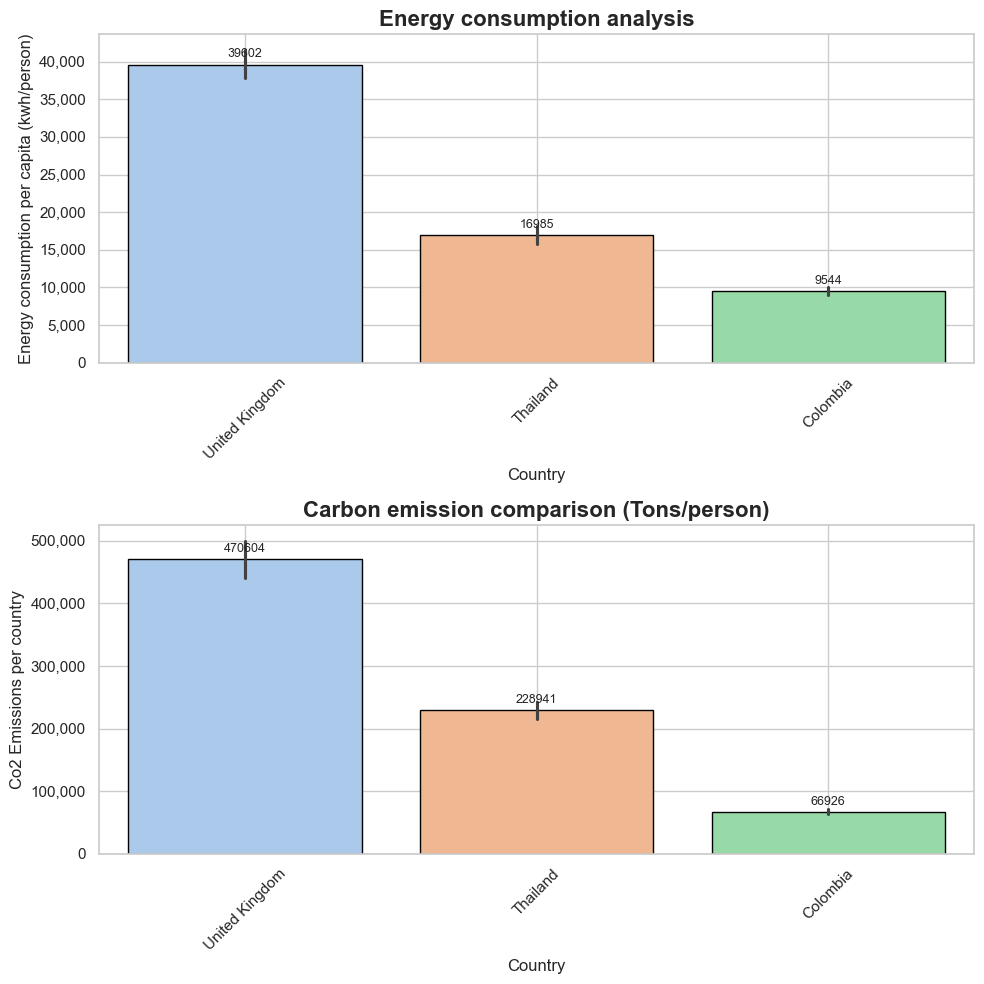

In [10]:
# Energy consumption analysis
plt.figure(figsize = (10, 10))
plt.subplot(2, 1, 1)
bar_plot(final_df,'Energy consumption per capita (kwh/person)', 'Energy consumption analysis')
plt.savefig('../images/1_Energy consumption analysis.png')

# CO2 emissions analysis:
plt.subplot(2, 1, 2)
bar_plot(final_df,'Co2 Emissions per country', 'Carbon emission comparison (Tons/person)')
plt.savefig('../images/2_Carbon emission comparison (Tons per person).png')

# Trends:

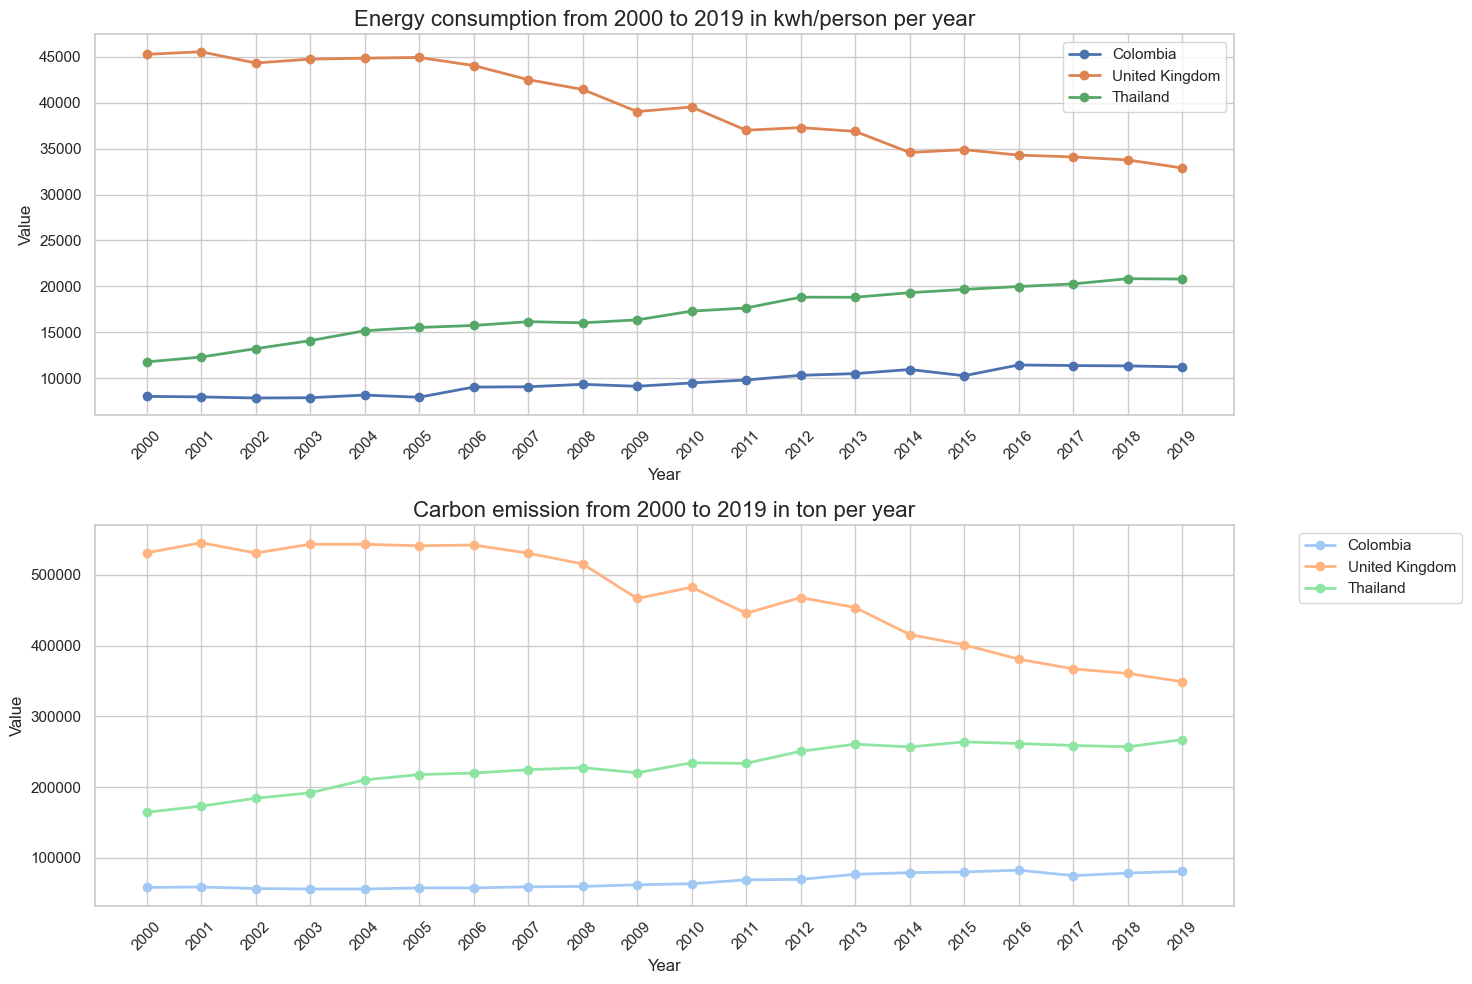

In [11]:
# RANGE TO PLOT (YEARS)
years = list(final_df['Year'].unique())

# GETTING THE DATA TO PLOT
# ENERGY:
colombia_energy = final_df[final_df['Entity'] == 'Colombia']['Energy consumption per capita (kwh/person)']
uk_energy       = final_df[final_df['Entity']   == 'United Kingdom']['Energy consumption per capita (kwh/person)']
thailand_energy = final_df[final_df['Entity']  == 'Thailand']['Energy consumption per capita (kwh/person)']

# CO2:
colombia_co2 = final_df[final_df['Entity']  == 'Colombia']['Co2 Emissions per country']
uk_co2       = final_df[final_df['Entity']  == 'United Kingdom']['Co2 Emissions per country']
thailand_co2  = final_df[final_df['Entity'] == 'Thailand']['Co2 Emissions per country']

# PLOT THEM INTO THE SAME PLOT
plt.figure(figsize = (15,10))

# PLOTTING ENERGY:
plt.subplot(2, 1, 1)
plot_trend(colombia_energy, uk_energy, thailand_energy, years, 'Energy consumption from 2000 to 2019 in kwh/person per year')

# PLOTTING CO2:
plt.subplot(2, 1, 2)
plot_trend(colombia_co2, uk_co2, thailand_co2, years, 'Carbon emission from 2000 to 2019 in ton per year')

# LAYOUT
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../images/3_Carbon energy trend.png')

# Grouping Energy and CO₂ Data for Selected Countries and Forecasting

/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

📊 Results for column: Colombia
             Actual  Predicted  Lower CI  Upper CI
2019-12-31  80230.0   79784.73  74957.57  84611.90
2020-12-31  82680.0   82234.74  77407.57  87061.90
2021-12-31  74990.0   83429.47  76602.83  90256.12
2022-12-31  78590.0   84624.21  76263.32  92985.11
2023-12-31  81040.0   85818.95  76164.62  95473.28

📈 Performance Scores:
MAE                     4028.63
MSE                 26174277.41
RMSE                    5116.08
Confidence Level            90%
dtype: object

------------------------------------------------------------



/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

📊 Results for column: Thailand
               Actual  Predicted   Lower CI   Upper CI
2019-12-31  264000.00  262449.99  250760.15  274139.83
2020-12-31  261600.01  272490.00  260800.15  284179.84
2021-12-31  258820.01  277890.00  261358.06  294421.93
2022-12-31  257049.99  283290.00  263042.59  303537.40
2023-12-31  267090.00  288690.00  265310.31  312069.68

📈 Performance Scores:
MAE                      15870.0
MSE                 327951373.62
RMSE                    18109.43
Confidence Level             90%
dtype: object

------------------------------------------------------------



/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

📊 Results for column: United Kingdom
               Actual  Predicted   Lower CI   Upper CI
2019-12-31  401079.99  351152.64  321135.52  381169.77
2020-12-31  380810.00  339342.65  309325.52  369359.77
2021-12-31  367000.00  329765.28  287314.65  372215.91
2022-12-31  360730.01  320187.91  268196.72  372179.10
2023-12-31  348920.01  310610.54  250576.29  370644.80

📈 Performance Scores:
MAE                       41496.2
MSE                 1741996580.21
RMSE                     41737.23
Confidence Level              90%
dtype: object

------------------------------------------------------------



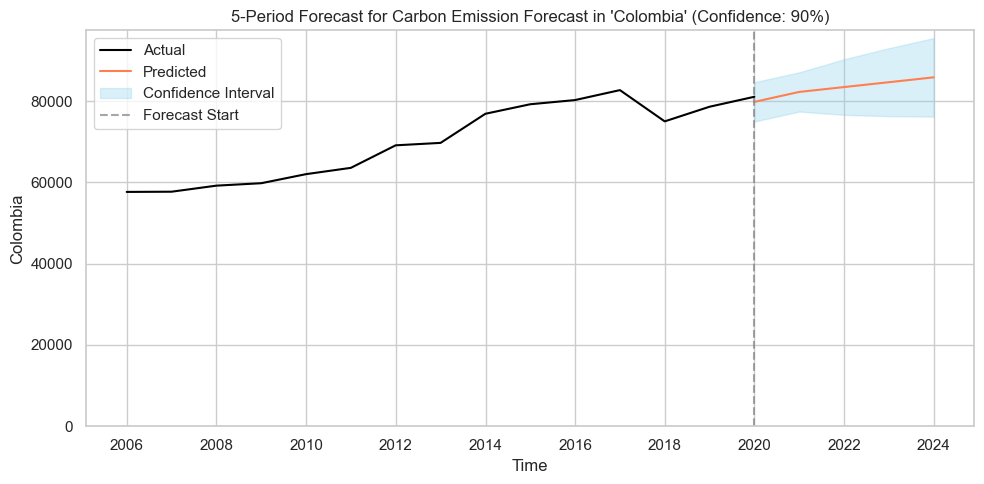

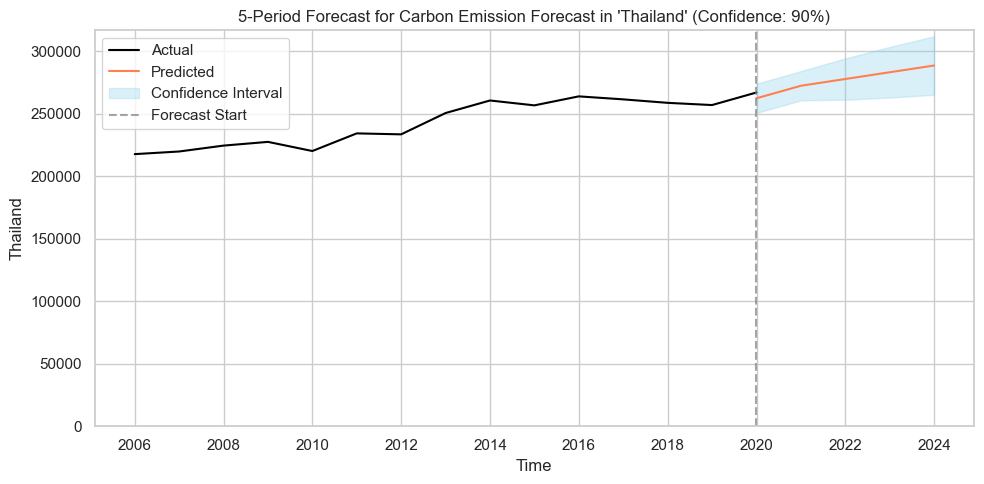

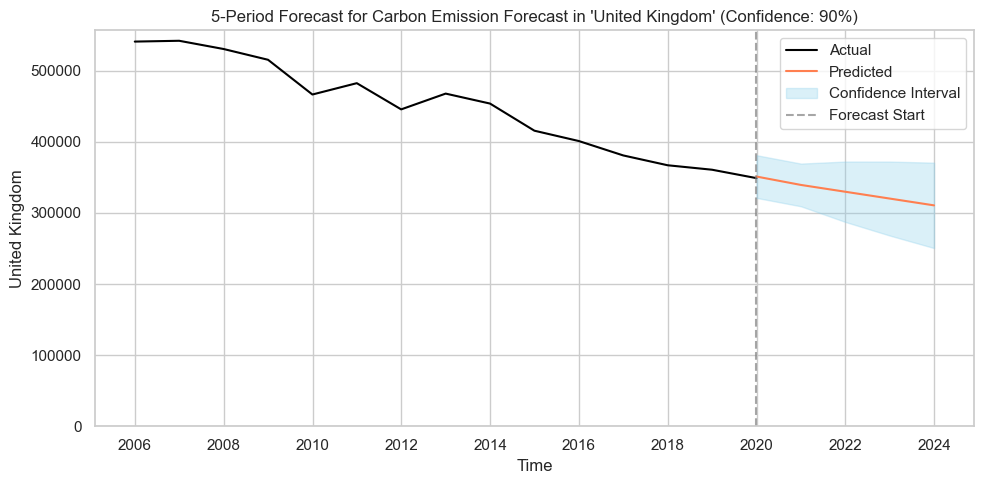

In [17]:
# DIVIDING THE DATA TO REORGANIZE IT (ENERGY):
colombia_df                     = final_df[final_df['Entity'] == 'Colombia'].reset_index(drop=True)
thailand_df                     = final_df[final_df['Entity'] == 'Thailand'].reset_index(drop=True)
united_kingdom_df               = final_df[final_df['Entity'] == 'United Kingdom'].reset_index(drop=True)

# CREATING A NEW DATA FRAME (CARBON):
total_carbon                    = pd.DataFrame({'Year':final_df['Year'].unique()})
total_carbon['Colombia']        = colombia_df['Co2 Emissions per country']
total_carbon['Thailand']        = thailand_df['Co2 Emissions per country']
total_carbon['United Kingdom']  = united_kingdom_df['Co2 Emissions per country']

# CREATING A NEW DATA FRAME:
total_energy                    = pd.DataFrame({'Year':final_df['Year'].unique()})
total_energy['Colombia']        = colombia_df['Energy consumption per capita (kwh/person)']
total_energy['Thailand']        = thailand_df['Energy consumption per capita (kwh/person)']
total_energy['United Kingdom']  = united_kingdom_df['Energy consumption per capita (kwh/person)']

# INDEX YEAR ENERGY:
total_energy['Year'] = pd.to_datetime(total_energy['Year'], format='%Y')
total_energy.index = total_energy['Year']

# INDEX YEAR CARBON:
total_carbon['Year'] = pd.to_datetime(total_carbon['Year'], format='%Y')
total_carbon.index = total_carbon['Year']

# DROPPING THE YEAR COLUMNS (NOW AN INDEX)
total_carbon = total_carbon.drop(columns='Year')
total_energy = total_energy.drop(columns='Year')

# Foecasting by AutoARIMA
forecaster = AutoARIMA(sp=1, suppress_warnings=True)
# forecasting CARBON
sktime_forecast(dataset=total_carbon, horizon=5, forecaster=forecaster, validation=False, title = 'Carbon Emission Forecast')

/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

📊 Results for column: Colombia
              Actual  Predicted  Lower CI  Upper CI
2019-12-31  10259.04   11616.42  11012.78  12220.06
2020-12-31  11435.30   11536.56  10932.92  12140.20
2021-12-31  11368.83   11675.24  10975.62  12374.85
2022-12-31  11332.25   11886.84  11051.08  12722.59
2023-12-31  11221.79   12068.24  11135.42  13001.05

📈 Performance Scores:
MAE                    633.22
MSE                 594135.42
RMSE                    770.8
Confidence Level          90%
dtype: object

------------------------------------------------------------



/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

📊 Results for column: Thailand
              Actual  Predicted  Lower CI  Upper CI
2019-12-31  19661.77   21309.24  20711.24  21907.24
2020-12-31  19981.58   21267.53  20669.53  21865.53
2021-12-31  20264.65   21742.68  20896.98  22588.38
2022-12-31  20834.09   22217.83  21182.07  23253.60
2023-12-31  20792.38   22692.98  21496.98  23888.98

📈 Performance Scores:
MAE                    1539.16
MSE                 2415883.66
RMSE                   1554.31
Confidence Level           90%
dtype: object

------------------------------------------------------------



/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and w

📊 Results for column: United Kingdom
              Actual  Predicted  Lower CI  Upper CI
2019-12-31  34890.32   33119.82  31547.37  34692.27
2020-12-31  34296.68   32242.08  30669.63  33814.53
2021-12-31  34098.81   31590.40  29366.63  33814.18
2022-12-31  33771.50   30938.73  28215.17  33662.29
2023-12-31  32893.76   30287.05  27142.15  33431.94

📈 Performance Scores:
MAE                    2354.6
MSE                 5693543.9
RMSE                  2386.11
Confidence Level          90%
dtype: object

------------------------------------------------------------



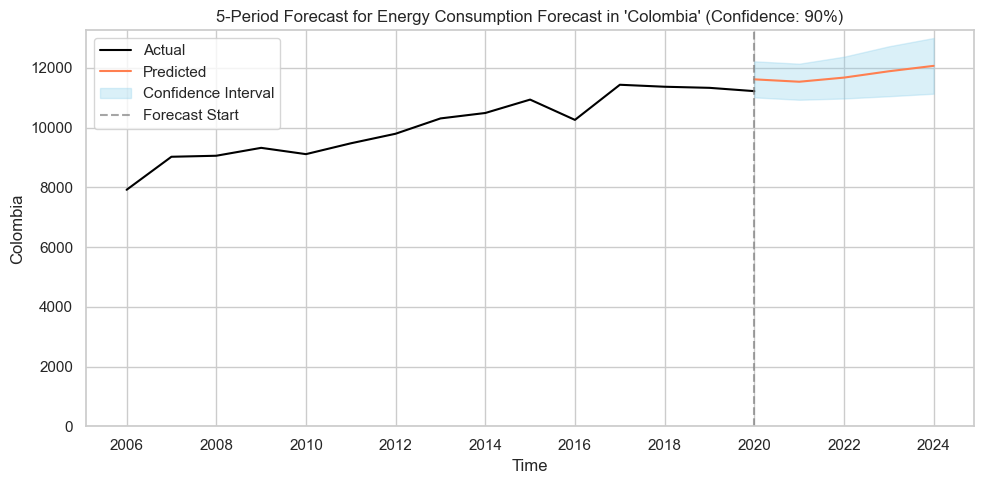

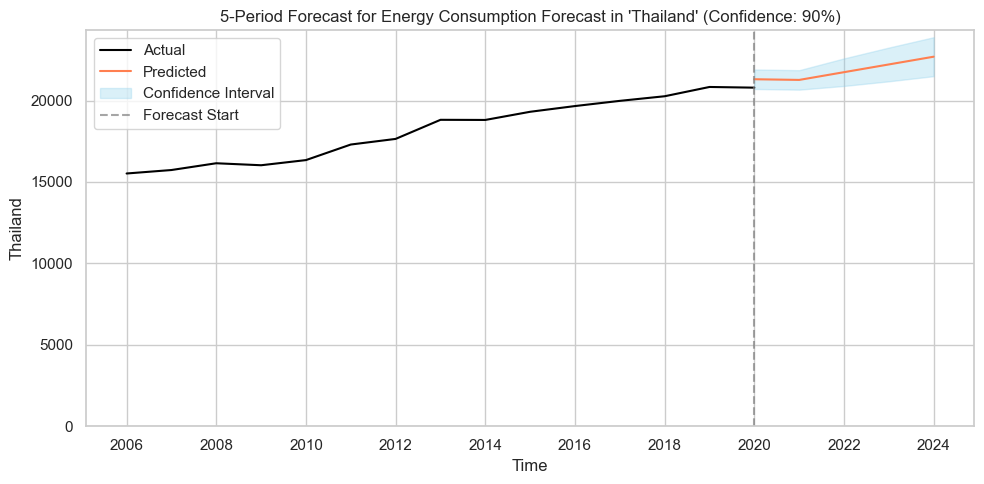

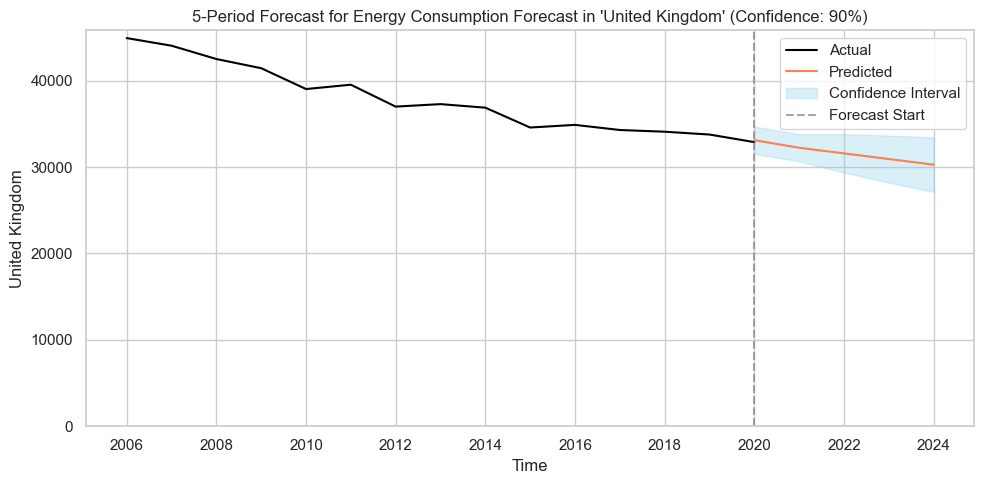

In [19]:
# forecasting ENERGY
sktime_forecast(dataset=total_energy, horizon=5, forecaster=forecaster, validation=False, title = 'Energy Consumption Forecast')